# Section 3: Sentiment and Emotion

Set up and config the environment

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("This script is running on Google Colab.")
else:
    print("This script is not running on Google Colab.")

This script is running on Google Colab.


In [ ]:
if IN_COLAB:
  !pip install transformers
else:
  pass

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
import nltk
nltk.download('punkt')

import collections
from collections import defaultdict

import transformers
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import time

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import scipy
from scipy.spatial.distance import euclidean

RANDOM_SEED = 40419837
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Load 'stories.json' file

In [ ]:
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive/')
  pth = '/content/drive/MyDrive/QUB MSc AI/ECS8054 - Natural Language Processing/\
Natural Language Processing - Final Assessment Project'
  print("Google Drive mounted successfully")

Mounted at /content/drive/
Google Drive mounted successfully


In [ ]:
with open(os.path.join(pth, 'stories.json'), 'r') as ifh:
    json_data = json.load(ifh)

df = pd.DataFrame(json_data)
df.head()

,index,genre,writer,quality,story_subject,action1,place,action2,story_object,ending,object_concept,story,question1,answer1,question2,answer2
0,0,thriller,Samuel Beckett,depressed,doctor,is originally from,Italy,save,worst enemy,sad,trombone,The shadowy arms of melancholy clung persisten...,Where was the protagonist's birthplace?,"""His origin lay nestled at the foot of the Alp...",What musical instrument is mentioned in the st...,"""A trombone, tarnished by time and disuse, lay..."
1,1,comedy,Lewis Carroll,rich,scientist,goes to,China,meet,sister,happy,dictionary,"Once there lived an affluent alchemist, boasti...",What does the Alchemist recognise about the fi...,"""He recognised the slice of golden eyes, the a...",How does the Alchemist feel towards his dictio...,"""He packed his graphite grey suitcase with ess..."
2,2,thriller,Samuel Beckett,angry,rockstar,lives in,France,meet,best friend,unexpected,centipede,Beneath the iron-grey veil of foreign skies re...,What did the entity long for?,"""His temperament, mirroring the azure ripples ...",What unexpected event altered the entity's jou...,"""But fate, in its quintessential unpredictabil..."
3,3,thriller,Enid Blyton,young,scientist,lives in,India,save,worst enemy,sad,lobster,"Once upon a time, in a land cradled in the arm...",Where did the man find himself one silent night?,"""The night when he held the essence of surviva...",What is a consistent companion to the man's me...,"""He relished the extraordinary robust flavour ..."
4,4,comedy,Charles Dickens,old,taxi driver,lives in,Texas,meet,best friend,unexpected,trolley,Upon a bright morning under the waving Lone St...,What did the gentleman find when he arrived at...,"""As he approached the familiar oak at the cres...",Why was his friend not at home to welcome him?,"""He opened it to find a note from his companio..."


In [ ]:
df.shape

(700, 16)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   index           700 non-null    int64 
 1   genre           700 non-null    object
 2   writer          700 non-null    object
 3   quality         700 non-null    object
 4   story_subject   700 non-null    object
 5   action1         700 non-null    object
 6   place           700 non-null    object
 7   action2         700 non-null    object
 8   story_object    700 non-null    object
 9   ending          700 non-null    object
 10  object_concept  700 non-null    object
 11  story           700 non-null    object
 12  question1       700 non-null    object
 13  answer1         700 non-null    object
 14  question2       700 non-null    object
 15  answer2         700 non-null    object
dtypes: int64(1), object(15)
memory usage: 87.6+ KB


## 3.1 Sentiment analysis with BERT.




Data exploration and preparation

In [ ]:
stories = df['story']
print(stories)

0      The shadowy arms of melancholy clung persisten...
1      Once there lived an affluent alchemist, boasti...
2      Beneath the iron-grey veil of foreign skies re...
3      Once upon a time, in a land cradled in the arm...
4      Upon a bright morning under the waving Lone St...
                             ...                        
695    In a place where tropical plants grew wild and...
696    In a world far removed from the routine tranqu...
697    In the heart of the tropics, nestled within th...
698    Once upon a chilly waning autumn evening, bene...
699    In the mighty metropolis, where stacks of bric...
Name: story, Length: 700, dtype: object


In [ ]:
def get_last_sentence(story):
    # Tokenize the story into sentences
    sentences = nltk.sent_tokenize(story)

    # Get the last sentence if sentences exist, otherwise, return an empty string
    last_sentence = sentences[-1] if sentences else ""
    return last_sentence

# Initialize a list to store the last sentences of each story
last_sentences = []

# Iterate through each story and extract the last sentence
for story in stories:
    last_sentence = get_last_sentence(story)
    last_sentences.append(last_sentence)

# Print the last sentences of the first five stories
for last_sentence in last_sentences[0:5]:
    print(f"Last Sentence: {last_sentence}")


Last Sentence: A paradoxical existence concluded, the inevitable collision of a will bound by duty, and a soul seared with bitterness reflected in the frosty depths of his gaze.
Last Sentence: Imbued with merry success, the alchemist decoded the complexity of his voyage, realising that his journey wasn't merely a geographical relocation, but a philosophical pursuit of connexion and familial unity.
Last Sentence: Be it mirth or pain, the rock star found his destination altered, his journey immured within his symphony of life.
Last Sentence: The briny whiff accentuating the quandary of a deserted battle and the sorrowful echo that resonated beyond the iron and steel of man-made marvels.
Last Sentence: "\n\nAs he steered his carriage back towards the twinkling lights of the city, vowing to rendezvous with his friend upon his return, he felt heartened that it wasn't just the gears in his vehicle that were still eager for motion; indeed, life and friendship were very much the same.


In [ ]:
endings = df['ending']
print(endings)

0             sad
1           happy
2      unexpected
3             sad
4      unexpected
          ...    
695         happy
696           sad
697         happy
698           sad
699           sad
Name: ending, Length: 700, dtype: object


In [ ]:
endings_count = df['ending'].value_counts()
print(endings_count)

unexpected    237
sad           234
happy         229
Name: ending, dtype: int64


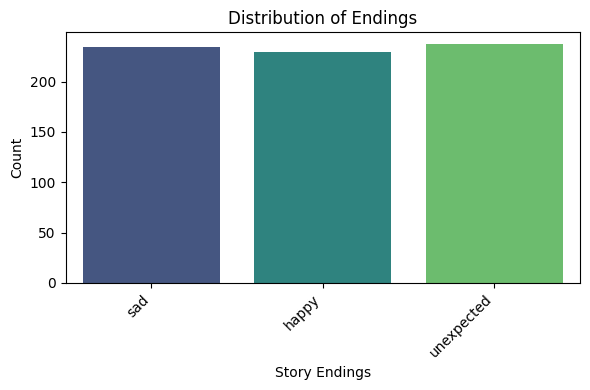

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='ending', hue='ending', data=df, palette='viridis', legend=False)
plt.xlabel('Story Endings')
plt.ylabel('Count')
plt.title('Distribution of Endings')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Label encoding

In [ ]:
label_encoder = LabelEncoder()

encoded_endings = label_encoder.fit_transform(endings)
print(encoded_endings)

[1 0 2 1 2 2 1 1 0 0 1 0 2 0 2 1 1 0 1 2 0 0 2 1 0 2 0 0 1 2 1 1 1 0 1 0 0
 1 1 1 2 2 2 2 1 2 2 1 0 1 2 0 0 0 0 1 2 1 2 2 0 0 0 2 2 1 0 0 0 2 1 0 2 1
 0 2 0 0 1 2 2 1 2 0 0 0 0 0 1 1 0 0 0 0 0 2 2 0 0 1 2 1 1 1 0 1 0 2 0 0 2
 2 2 0 0 0 0 2 1 2 0 2 0 1 0 0 0 2 0 2 1 1 2 2 1 2 1 2 1 0 0 0 2 1 1 2 1 0
 2 0 1 1 2 2 1 2 0 1 2 0 2 0 1 2 2 0 0 2 2 0 0 1 1 0 1 2 2 0 1 1 2 2 0 0 1
 1 1 0 1 0 2 1 0 0 1 1 0 2 1 1 0 2 2 0 1 1 0 2 0 0 0 1 2 2 0 2 1 0 1 1 2 1
 2 1 1 0 0 2 0 2 1 2 0 2 1 0 2 1 1 1 2 2 1 0 0 2 1 2 0 0 1 2 0 1 2 0 1 0 0
 0 1 0 2 0 2 1 1 1 1 0 2 2 2 1 1 0 0 2 2 1 1 1 2 2 0 2 2 0 0 2 0 1 2 1 2 0
 2 0 0 0 1 1 2 1 1 0 0 0 2 0 1 2 1 1 2 1 2 0 1 0 0 0 1 0 2 2 0 1 0 0 0 2 2
 1 0 2 1 1 1 2 1 1 2 0 2 2 0 2 2 2 2 0 2 1 1 1 2 1 1 0 0 0 0 0 1 1 2 2 0 2
 2 2 0 2 0 2 1 1 0 1 0 1 2 0 2 0 2 1 0 2 2 0 1 0 2 2 2 2 1 0 1 2 0 0 0 2 1
 2 2 1 1 1 1 2 2 2 2 1 0 0 0 2 0 0 0 2 2 1 1 2 2 2 0 0 0 0 0 0 1 1 2 1 2 0
 2 0 1 0 1 2 1 0 1 1 2 1 0 1 1 1 0 2 1 2 2 2 2 0 2 2 0 2 2 0 0 1 2 0 1 1 1
 2 2 1 1 2 0 1 1 2 2 0 2 

In [ ]:
encoding_mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))

print("Encoding Mapping:")
print(encoding_mapping)

Encoding Mapping:
{0: 'happy', 1: 'sad', 2: 'unexpected'}


In [ ]:
df['encoded_ending'] = encoded_endings

df[['ending', 'encoded_ending']].sample(5)

,ending,encoded_ending
239,sad,1
530,unexpected,2
306,happy,0
615,sad,1
46,unexpected,2


In [ ]:
endings_labels = label_encoder.classes_
print(endings_labels)

['happy' 'sad' 'unexpected']


Create custom dataset class for sentiment analysis

In [ ]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        # Initialize dataset with texts, labels, tokenizer, and maximum sequence length
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.texts)

    def __getitem__(self, idx):
      # Retrieve the text and label for the given index
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize the text using the provided tokenizer
        encoding = self.tokenizer(
            text, return_tensors='pt',
            max_length=self.max_length,
            padding='max_length',
            truncation=True)

        # Flatten and return input_ids, attention_mask, and label as tensors
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label) # Convert label to tensor
        }

Build BERT Classifier

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        # Initialize the BERT-based classifier
        super(BERTClassifier, self).__init__()

        # Load pre-trained BERT model
        self.bert = BertModel.from_pretrained(bert_model_name)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.1)

        # Fully connected layer for classification
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        # Forward pass through BERT model
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Extract pooled output
        pooled_output = outputs.pooler_output

        # Apply dropout for regularization
        x = self.dropout(pooled_output)

        # Pass through fully connected layer for classification
        logits = self.fc(x)

        return logits

Define train() function

In [ ]:
def train(model, data_loader, optimizer, scheduler, device):
    # Set the model to training mode
    model.train()

    # Initialize variables for tracking loss and accuracy
    total_loss = 0
    total_correct = 0
    total_samples = 0

    # Iterate through each batch in the data loader
    for batch in data_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Move input data and labels to the device (GPU or CPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass through the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Calculate the loss
        loss = nn.CrossEntropyLoss()(outputs, labels)
        total_loss += loss.item()

        # Compute the number of correct predictions
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        scheduler.step() # Adjust learning rate

    # Compute average loss and accuracy
    return total_loss / len(data_loader), total_correct / total_samples

Define evaluate() function

In [ ]:
def evaluate(model, data_loader, device):
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables for tracking loss and accuracy
    total_loss = 0
    total_correct = 0
    total_samples = 0

    # Disable gradient calculation for evaluation
    with torch.no_grad():
        # Iterate through each batch in the data loader
        for batch in data_loader:
            # Move input data and labels to the device (GPU or CPU)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass through the model
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Calculate the loss
            loss = nn.CrossEntropyLoss()(outputs, labels)
            total_loss += loss.item()

            # Compute the number of correct predictions
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    # Compute average loss and accuracy
    return total_loss / len(data_loader), total_correct / total_samples

Parameters

In [ ]:
bert_model_name = 'bert-base-uncased'
num_classes = len(endings_labels) #3
max_length = 512
batch_size = 16
num_epochs = 10
learning_rate = 5e-6

Splitting data

In [ ]:
for last_sentence in last_sentences[0:4]:
    print(f"Last Sentence: {last_sentence}")
print(len(last_sentences))

print("\nEncoded Endings:\n", encoded_endings)
print(len(encoded_endings))

Last Sentence: A paradoxical existence concluded, the inevitable collision of a will bound by duty, and a soul seared with bitterness reflected in the frosty depths of his gaze.
Last Sentence: Imbued with merry success, the alchemist decoded the complexity of his voyage, realising that his journey wasn't merely a geographical relocation, but a philosophical pursuit of connexion and familial unity.
Last Sentence: Be it mirth or pain, the rock star found his destination altered, his journey immured within his symphony of life.
Last Sentence: The briny whiff accentuating the quandary of a deserted battle and the sorrowful echo that resonated beyond the iron and steel of man-made marvels.
700

Encoded Endings:
 [1 0 2 1 2 2 1 1 0 0 1 0 2 0 2 1 1 0 1 2 0 0 2 1 0 2 0 0 1 2 1 1 1 0 1 0 0
 1 1 1 2 2 2 2 1 2 2 1 0 1 2 0 0 0 0 1 2 1 2 2 0 0 0 2 2 1 0 0 0 2 1 0 2 1
 0 2 0 0 1 2 2 1 2 0 0 0 0 0 1 1 0 0 0 0 0 2 2 0 0 1 2 1 1 1 0 1 0 2 0 0 2
 2 2 0 0 0 0 2 1 2 0 2 0 1 0 0 0 2 0 2 1 1 2 2 1 2 1 2 1 0

In [ ]:
X = np.array(last_sentences)
y = np.array(encoded_endings)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5,
                                                random_state=RANDOM_SEED)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(560,) (70,) (70,)
(560,) (70,) (70,)


Initialize tokenizer, dataset, and data loader

In [ ]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_dataset = SentimentAnalysisDataset(X_train, y_train, tokenizer, max_length)
val_dataset = SentimentAnalysisDataset(X_val, y_val, tokenizer, max_length)
test_dataset = SentimentAnalysisDataset(X_test, y_test, tokenizer, max_length)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(val_dataset, batch_size=batch_size)

Set up the device and model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Selected device:", device)

model = BERTClassifier(bert_model_name, num_classes).to(device)

Selected device: cuda


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Set up optimizer and learning rate scheduler

In [ ]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model Training

In [ ]:
start_time = time.time()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Iterate over epochs
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Perform training for the current epoch and calculate training loss and accuracy
    train_loss, train_accuracy = train(model, train_dataloader, optimizer,
                                       scheduler, device)

    # Evaluate the model on validation data and calculate validation loss and accuracy
    val_loss, val_accuracy = evaluate(model, val_dataloader, device)

    # Print training and validation metrics for the current epoch
    print(f"Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}\n")

    # Append training and validation metrics to respective lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

end_time = time.time()
elapsed_time = end_time - start_time # Calculate the total runtime
print(f"\nTotal runtime: {elapsed_time} seconds")

Epoch 1/10
Training Loss: 1.1107, Accuracy: 0.3714
Validation Loss: 1.0886, Accuracy: 0.4429

Epoch 2/10
Training Loss: 1.0493, Accuracy: 0.4446
Validation Loss: 1.0440, Accuracy: 0.5143

Epoch 3/10
Training Loss: 0.9707, Accuracy: 0.6036
Validation Loss: 0.9793, Accuracy: 0.5429

Epoch 4/10
Training Loss: 0.8850, Accuracy: 0.6482
Validation Loss: 0.9377, Accuracy: 0.5857

Epoch 5/10
Training Loss: 0.7859, Accuracy: 0.7054
Validation Loss: 0.9125, Accuracy: 0.5857

Epoch 6/10
Training Loss: 0.7233, Accuracy: 0.7857
Validation Loss: 0.8609, Accuracy: 0.6857

Epoch 7/10
Training Loss: 0.6800, Accuracy: 0.7768
Validation Loss: 0.8462, Accuracy: 0.6714

Epoch 8/10
Training Loss: 0.6341, Accuracy: 0.8161
Validation Loss: 0.8336, Accuracy: 0.6857

Epoch 9/10
Training Loss: 0.6065, Accuracy: 0.8286
Validation Loss: 0.8288, Accuracy: 0.6857

Epoch 10/10
Training Loss: 0.5955, Accuracy: 0.8304
Validation Loss: 0.8289, Accuracy: 0.6857


Total runtime: 515.2722425460815 seconds


Visualization of performance over epochs

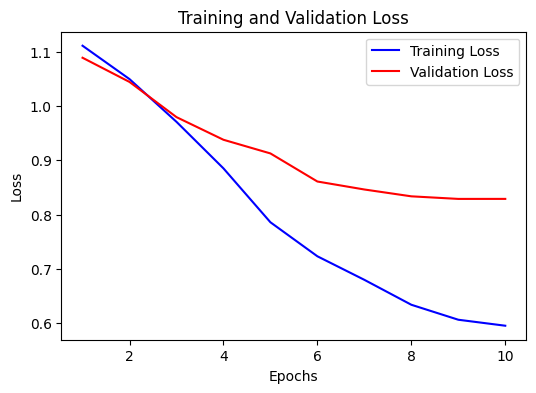

In [ ]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

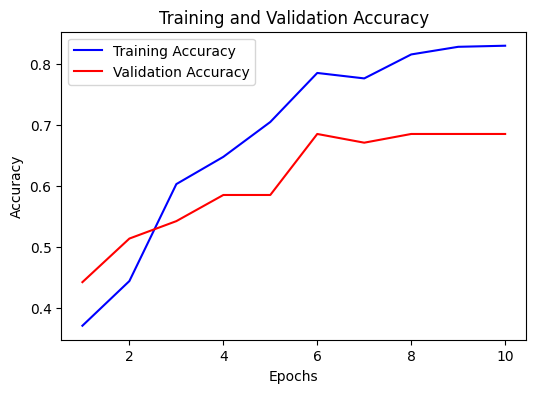

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Model Evaluation

In [ ]:
test_losses = []
test_accuracies = []
test_predictions = []
test_actual_labels = []

model.eval() # Set the model to evaluation mode
with torch.no_grad(): # Disable gradient calculation
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device) # Move input IDs to device (GPU/CPU)
        attention_mask = batch['attention_mask'].to(device) # Move attention masks to device
        labels = batch['label'].to(device) # Move labels to device
        outputs = model(input_ids=input_ids, attention_mask=attention_mask) # Forward pass
        loss = nn.CrossEntropyLoss()(outputs, labels) # Calculate loss
        test_losses.append(loss.item()) # Append loss to test_losses list
        _, predicted = torch.max(outputs, 1) # Get predicted labels
        test_predictions.extend(predicted.cpu().tolist())  # Extend test_predictions list
        test_actual_labels.extend(labels.cpu().tolist()) # Extend test_actual_labels list

test_accuracy = accuracy_score(test_actual_labels, test_predictions) # Calculate test accuracy
test_accuracies.append(test_accuracy) # Append test accuracy to test_accuracies list

# Generate classification report
classification_rep = classification_report(test_actual_labels,
                                           test_predictions, zero_division=1)

# Print test loss, accuracy, and classification report
print(f"Testing Loss: {np.mean(test_losses):.4f}, Accuracy: {test_accuracy:.4f}")
print("Classification Report:")
print(classification_rep)

Testing Loss: 0.8289, Accuracy: 0.6857
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.78      0.71        23
           1       0.82      0.69      0.75        26
           2       0.60      0.57      0.59        21

    accuracy                           0.69        70
   macro avg       0.69      0.68      0.68        70
weighted avg       0.70      0.69      0.69        70



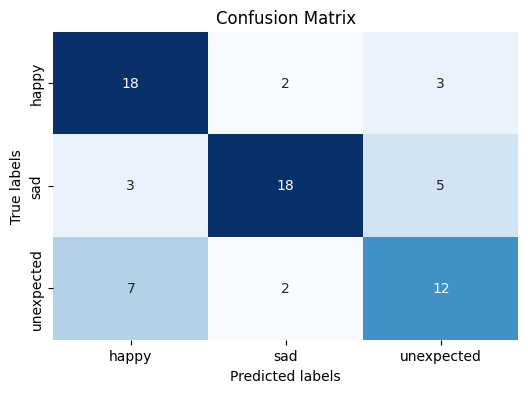

In [ ]:
conf_matrix = confusion_matrix(test_actual_labels, test_predictions)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=endings_labels, yticklabels=endings_labels)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

## 3.2 Emotional content of stories


Data exploration and preparation

In [ ]:
qualities = df['quality']
print(qualities)

0      depressed
1           rich
2          angry
3          young
4            old
         ...    
695         poor
696      excited
697         rich
698        young
699    depressed
Name: quality, Length: 700, dtype: object


In [ ]:
qualities_count = df['quality'].value_counts()
print(qualities_count)

old          122
excited      108
rich          99
young         99
angry         95
depressed     94
poor          83
Name: quality, dtype: int64


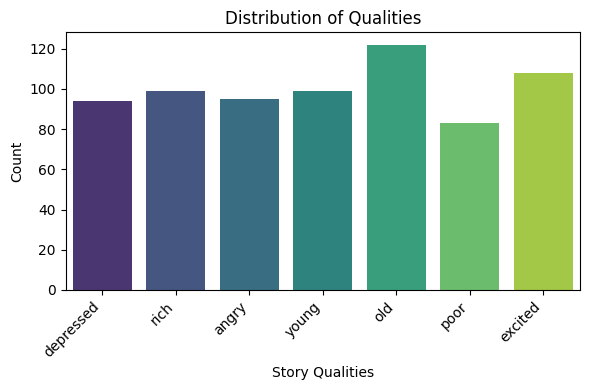

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='quality', hue='quality', data=df, palette='viridis',
              legend=False)
plt.xlabel('Story Qualities')
plt.ylabel('Count')
plt.title('Distribution of Qualities')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
quality_labels = df['quality'].unique()
print(quality_labels)

['depressed' 'rich' 'angry' 'young' 'old' 'poor' 'excited']


Initialize the pre-trained model and tokenizer

In [ ]:
model_name = "bhadresh-savani/bert-base-uncased-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Computing emotion vectors for each stories

In [ ]:
def get_prob_distribution(sentence):
    # Tokenize the sentence using the tokenizer
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)

    # Pass the tokenized input to the model and retrieve the outputs
    with torch.no_grad():
        outputs = model(**inputs)

    # Retrieve the logits and calculate the softmax probabilities
    logits = outputs.logits
    prob_distributions = torch.softmax(logits, dim=1).squeeze().tolist()
    return prob_distributions

def get_emotion_vector(story):
    # Split the story into sentences
    sentences = story.split('.')

    # Initialize an empty list to store probability distributions for each sentence
    prob_distributions = []

    # Iterate through each sentence in the story
    for sentence in sentences:
        # Obtain the probability distribution for the current sentence
        prob_distribution = get_prob_distribution(sentence)
        prob_distributions.append(prob_distribution)

    # Convert the list of probability distributions into a numpy array
    prob_distributions = np.array(prob_distributions)

    # Calculate the mean of the probability distributions across all sentences to obtain the emotion vector
    emotion_vector = np.mean(prob_distributions, axis=0)
    return emotion_vector

In [ ]:
%%time

# Zip qualities and stories together into a list of tuples
qualities_stories = list(zip(qualities, stories))

print(qualities_stories[0])
print(len(qualities_stories))

# Initialize an empty list to store emotion data
emotion_data = []

# Loop through each quality-story pair
for quality, story in qualities_stories:
    # Get the emotion vector for the current story
    emotion_vector = get_emotion_vector(story)

    # Append a tuple of quality and emotion vector to emotion_data list
    emotion_data.append((quality, emotion_vector))

('depressed', "The shadowy arms of melancholy clung persistently to him, a man whose mantle of professional duty would dress his days. Trapped within the confines of an ivory fortress, he bore the weight of split lives; where the bitter taint of a personal vendetta seeped into his terrain of medicinal providence.\\n\\nHis origin lay nestled at the foot of the Alps, where the winding cobblestone streets echoed with the romance of life's opera - an aria spilling from each open window, a vivid dance in every piazza, and a crescendo resonant in the hallowed halls of culture. This was the birthplace of his existence, although for him it was but an echo in the ether, buried under years of accumulated strife.\\n\\nHis antagonist, the unfortunate wretch harbored the poignant prologue of their shared story. His foe, death-bound and reluctant, yet a product of the very hands assigned to deliver him toward the light. Their dyadic relationship etched in irony, his obligation and the mutual contemp

In [ ]:
emotion_data[0:5]

[('depressed',
  array([0.49800423, 0.13435364, 0.02130741, 0.25083595, 0.0897302 ,
         0.00576853])),
 ('rich',
  array([0.01212673, 0.60268779, 0.13287489, 0.07406489, 0.16415166,
         0.01409402])),
 ('angry',
  array([0.06081022, 0.45840676, 0.07378564, 0.22117566, 0.1746403 ,
         0.0111814 ])),
 ('young',
  array([0.10834959, 0.60066447, 0.01279334, 0.14520607, 0.11940608,
         0.01358047])),
 ('old',
  array([0.01909312, 0.58524106, 0.0548008 , 0.04299419, 0.23779053,
         0.0600803 ]))]

Investigation on emotion vectors across different emotions

In [ ]:
emotion_vectors = defaultdict(list)

# Loop through each quality and emotion vector in emotion_data
for quality, emotion_vector in emotion_data:
    # Append each emotion vector to the list corresponding to its quality in emotion_vectors
    emotion_vectors[quality].append(emotion_vector)

average_emotion_vectors = {}

# Calculate the average emotion vector for each quality
for quality, vectors in emotion_vectors.items():
    # Compute the mean of all vectors for a particular quality
    average_vector = np.mean(vectors, axis=0)
    # Store the average emotion vector for the quality
    average_emotion_vectors[quality] = average_vector

# Print out the average emotion vectors for each quality
for quality, avg_vector in average_emotion_vectors.items():
    print(f"Quality: {quality}")
    print(f"Average Emotion Vector: {avg_vector}")
    print("=" * 50)

Quality: depressed
Average Emotion Vector: [0.22984233 0.34414134 0.07940505 0.16545085 0.15531402 0.0258464 ]
Quality: rich
Average Emotion Vector: [0.15111909 0.41195901 0.09717275 0.15279818 0.16009636 0.02685461]
Quality: angry
Average Emotion Vector: [0.17027746 0.32041326 0.08489074 0.2280493  0.16894298 0.02742626]
Quality: young
Average Emotion Vector: [0.15337873 0.38722349 0.09860294 0.16398756 0.17216136 0.02464591]
Quality: old
Average Emotion Vector: [0.17901032 0.41856603 0.09637976 0.13461057 0.14449015 0.02694316]
Quality: poor
Average Emotion Vector: [0.18454043 0.35873006 0.09316767 0.17093216 0.170681   0.02194869]
Quality: excited
Average Emotion Vector: [0.14143092 0.43868967 0.08531796 0.132928   0.1629448  0.03868865]


Investigation using Euclidean Distance

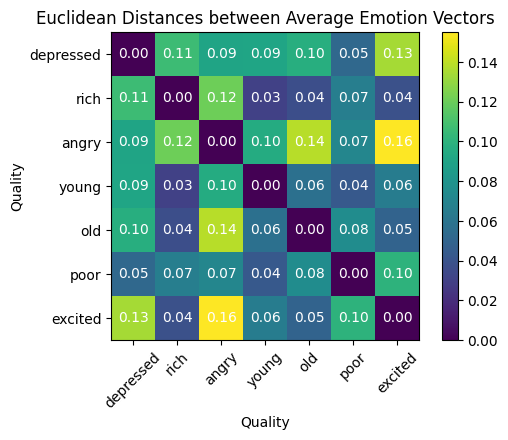

In [ ]:
distances = {}

# Calculate Euclidean distances between average emotion vectors for all pairs of qualities
for quality1 in average_emotion_vectors:
    distances[quality1] = {}
    for quality2 in average_emotion_vectors:
        # Calculate Euclidean distance between average emotion vectors for quality1 and quality2
        distances[quality1][quality2] = euclidean(average_emotion_vectors[quality1],
                                                  average_emotion_vectors[quality2])

# Create a list of qualities
qualities = list(average_emotion_vectors.keys())

# Create a distance matrix using the calculated distances
dist_matrix = np.array([[distances[quality1][quality2] for quality2 in qualities] for quality1 in qualities])

# Plot the heatmap of the distance matrix
plt.figure(figsize=(6, 4))
heatmap = plt.imshow(dist_matrix, interpolation='nearest')

# Add text annotations for each cell in the heatmap
for i in range(len(qualities)):
    for j in range(len(qualities)):
        plt.text(j, i, f'{dist_matrix[i, j]:.2f}', ha='center',
                 va='center', color='white')

plt.colorbar(heatmap)
plt.xticks(np.arange(len(qualities)), qualities, rotation=45)
plt.yticks(np.arange(len(qualities)), qualities)
plt.title('Euclidean Distances between Average Emotion Vectors')
plt.xlabel('Quality')
plt.ylabel('Quality')
plt.show()

Investigation using Cosine Similarity

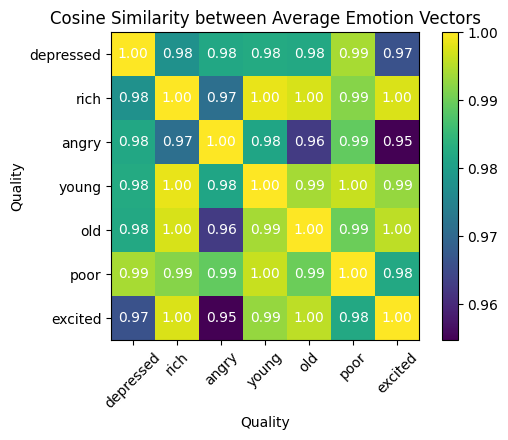

In [ ]:
similarities = cosine_similarity(list(average_emotion_vectors.values()))

# Create a heatmap plot for cosine similarities
plt.figure(figsize=(6, 4))
heatmap = plt.imshow(similarities, interpolation='nearest')

# Add text annotations for each cell in the heatmap
for i in range(len(qualities)):
    for j in range(len(qualities)):
        plt.text(j, i, f'{similarities[i, j]:.2f}', ha='center',
                 va='center', color='white')

plt.colorbar(heatmap)
plt.xticks(np.arange(len(qualities)), qualities, rotation=45)
plt.yticks(np.arange(len(qualities)), qualities)
plt.title('Cosine Similarity between Average Emotion Vectors')
plt.xlabel('Quality')
plt.ylabel('Quality')
plt.show()

Cluster Analysis

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


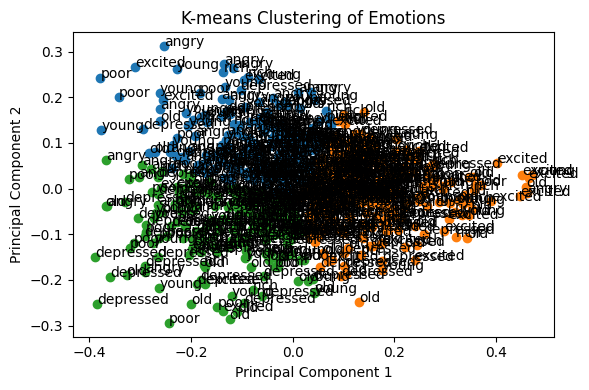

In [ ]:
# Extracting qualities from emotion_data
qualities = [quality for quality, _ in emotion_data]

# Mapping qualities to cluster indices
quality_to_cluster = {quality: i for i, quality in enumerate(set(qualities))}

# Assigning clusters based on quality
clusters = [quality_to_cluster[quality] for quality, _ in emotion_data]

# Extracting emotion vectors from emotion_data
emotion_vectors = [vec for _, vec in emotion_data]

# Applying K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(emotion_vectors)
clusters = kmeans.labels_

# Performing PCA for dimensionality reduction to 2 components
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(emotion_vectors)

# Plotting the K-means clustering results in 2D
plt.figure(figsize=(6, 4))

# Scatter plotting each point with color based on assigned cluster and labeling with corresponding quality
for i, point in enumerate(reduced_data):
    plt.scatter(point[0], point[1], color=plt.cm.tab10(clusters[i]), marker='o')
    plt.text(point[0], point[1], qualities[i])

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering of Emotions')
plt.tight_layout()
plt.show()